# Pickle compression comparison

[Python pickles](https://docs.python.org/3/library/pickle.html) are serialized representations of objects, generally stored as binary files.

> "pickling" refers to the process of converting a Python object into a stream of bytes, which can then be stored in a file or transferred over a network. This serialized form of the object can later be "unpickled" to recreate the original object

Some common usages of pickles in machine learning:
- images, binary raw input or descriptor data
- pre-trained models (numpy matrices, and pandas dataframes)

Whatever each pickle might represent, real-world applications can yield **file sizes easily reaching the gigabyte mark, or even larger**.

## Reasons to compress

Maybe you wantd to save provider charges by using a smaller and cheaper pod, with less memory.

Maybe you care about performance, but can't give up on saving disk space or reducing data transfer rates.


## Contenders

The actual choice of algorithm will depend on your circumstances, let's compare three popular algorithms

- [bzip2](https://docs.python.org/3/library/bz2.html)
- [gzip](https://docs.python.org/3/library/gzip.html)
- [blosc2](https://github.com/Blosc/python-blosc2)

> Blosc is a high performance compressor optimized for binary data (i.e. floating point numbers, integers and booleans, although it can handle string data too).

The same principles shown here can be applied to other algorithms.



In [18]:

import bz2, gzip, blosc2
import _pickle as cPickle
import pickle
import pandas

def load_plain(file):
    with open(file, "rb") as f:
      return cPickle.load(f)

def load_pandas(file):
    df = pandas.read_csv(file)
    return df

def dump_plain(file, data):
    with open(file, "wb") as f:
      return cPickle.dump(data,f)


def compress_pickle_b2z(file, data):
    with bz2.BZ2File(file, 'wb') as f:
        cPickle.dump(data, f)

def decompress_pickle_b2z(file):
    data = bz2.BZ2File(file, 'rb')
    return cPickle.load(data)


def decompress_pickle_gzip(file):
    with open(file, 'rb') as f:
        return cPickle.loads(gzip.decompress(f.read()))

def compress_pickle_gzip(file, data):
    with open(file, 'wb') as f:
        f.write(gzip.compress(cPickle.dumps(data)))


def decompress_pickle_blosc2(file):
    with open(file, 'rb') as f:
        return cPickle.loads(blosc2.decompress(f.read()))

def compress_pickle_blosc2(file, data):
    blosc2.MAX_BUFFERSIZE = 8 * 1024 * 1024 * 1024
    with open(file, 'wb') as f:
        f.write(blosc2.compress(cPickle.dumps(data)))



## Datablist (around 16MB)

Let's download the ´customers-100000.csv´ file from [datablist github repo](https://github.com/datablist/sample-csv-files)

We'll turn the pandas frame into a pickle, then compress it with each algorithm.

In [11]:
df = pandas.read_csv('../data/datablist/customers-100000.csv')
dump_plain('../data/datablist/customers-100000.pickle', df)

## Inspecting the pickle

Let's inspect the generated file.

In [ ]:
import pickletools


def inspect_pickle(pickle_path):
    with open(pickle_path, 'rb') as f:
       data = f.read()
    pickletools.dis(data)

inspect_pickle('../data/datablist/customers-100000.pickle')

The inspection confirms it's a pandas DataFrame

```
    0: \x80 PROTO      4
    2: \x95 FRAME      276
   11: \x8c SHORT_BINUNICODE 'pandas.core.frame'
   30: \x94 MEMOIZE    (as 0)
   31: \x8c SHORT_BINUNICODE 'DataFrame'
```

## Compressing it

Let's compress with each algorithm.

In [15]:
train = load_plain('../data/datablist/customers-100000.pickle')

compress_pickle_b2z("../data/datablist/customers-100000.pbz2", train)
compress_pickle_gzip("../data/datablist/customers-100000.gzip", train)
compress_pickle_blosc2("../data/datablist/customers-100000.blosc2", train)

As with any pickle, any of the three zipped files can be used to restore the original object.

In [ ]:
df = decompress_pickle_gzip("../data/customers-100000.gzip")
df.head()

Let's record the decompression overhead.

In [ ]:
%timeit decompress_pickle_gzip("../data/datablist/customers-100000.gzip")
%timeit decompress_pickle_b2z("../data/datablist/customers-100000.pbz2")
%timeit decompress_pickle_blosc2("../data/datablist/customers-100000.blosc2")


## Visualizing results

Now let's compare files sizes, and compression rates.

First a class to hold results:

In [12]:
import os

class PerformanceStats:
    def __init__(self, filename, method):
        self.method = method
        self.filename = filename
        self.original = 0.0
        self.compressed = 0.0
        self.ratio = 1

    def get_ratio(self):
        pickle_path = f"{self.filename}.pickle"
        file_path = f"{self.filename}.{self.method}"

        return os.path.getsize(file_path)/os.path.getsize(pickle_path)
    



Then plot the results:

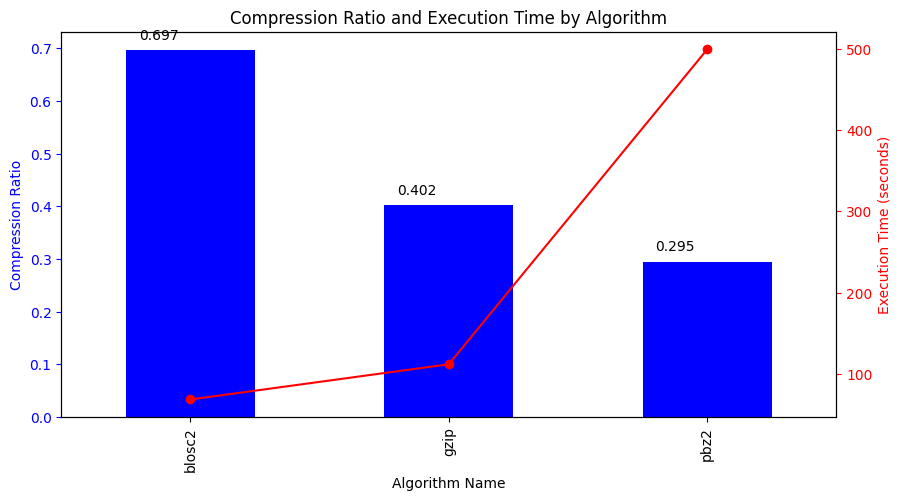

In [15]:
import matplotlib.pyplot as plt

def plot_performance_stats(df):
    pivot_table = df.pivot_table(index='algorithm_name', values=['compression_ratio', 'execution_time'], aggfunc='mean')

    fig, ax1 = plt.subplots(figsize=(10, 5))

    bars = pivot_table['compression_ratio'].plot(kind='bar', ax=ax1, color='b')
    ax1.set_ylabel('Compression Ratio', color='b')
    ax1.tick_params('y', colors='b')

    # Add actual values to bars
    for i, v in enumerate(pivot_table['compression_ratio']):
        ax1.text(i-0.2, v+0.02, str(round(v, 3)), color='black', fontsize=10)

    ax2 = ax1.twinx()

    pivot_table['execution_time'].plot(kind='line', ax=ax2, color='r', marker='o')
    ax2.set_ylabel('Execution Time (seconds)', color='r')
    ax2.tick_params('y', colors='r')

    ax1.set_xlabel('Algorithm Name')
    ax1.set_title('Compression Ratio and Execution Time by Algorithm')

    # show the plot
    plt.show()



data = {'compression_ratio': [
            PerformanceStats('../data/datablist/customers-100000', 'gzip').get_ratio(),
            PerformanceStats('../data/datablist/customers-100000', 'pbz2').get_ratio(), 
            PerformanceStats('../data/datablist/customers-100000', 'blosc2').get_ratio()],
        'execution_time': [112, 499, 68.7],
        'algorithm_name': ['gzip', 'pbz2', 'blosc2']}

plot_performance_stats(pandas.DataFrame(data))




## Results Analysis

That was an interesting result:

- blosc2 had best loading time, but worse compression rate

- pbz2 was twice as efficent for compression, but ~10x slower


# Larger pickles

## Failed attempt

Our first attempt of a large pickle file was too ambitious.

The pickle had about ~3GB
https://www.kaggle.com/code/columbia2131/speed-up-reading-csv-to-pickle/input

The blosc2 algorithm failed with `out of memory` exception multiple times (even on a 32GB RAM machine)

## globo.com news interactions pickle

Let's try with another pickle of about ~364MB

https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom


In [6]:
def compress_multiple(file_path):
    train = load_plain(f'{file_path}.pickle')

    compress_pickle_blosc2(f'{file_path}.blosc2', train)
    compress_pickle_b2z(f'{file_path}.pbz2', train)
    compress_pickle_gzip(f'{file_path}.gzip', train)

compress_multiple('../data/globo.com/articles_embeddings')



Let's record the decompression times

In [ ]:
%timeit decompress_pickle_gzip("../data/globo.com/articles_embeddings.gzip")
%timeit decompress_pickle_b2z("../data/globo.com/articles_embeddings.pbz2")
%timeit decompress_pickle_blosc2("../data/globo.com/articles_embeddings.blosc2")

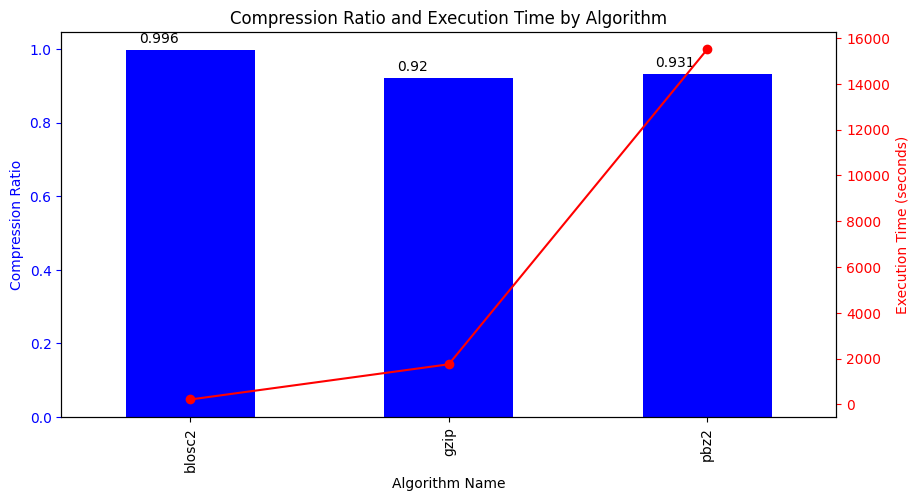

In [20]:

data = {'compression_ratio': [
            PerformanceStats('../data/globo.com/articles_embeddings', 'gzip').get_ratio(),
            PerformanceStats('../data/globo.com/articles_embeddings', 'pbz2').get_ratio(), 
            PerformanceStats('../data/globo.com/articles_embeddings', 'blosc2').get_ratio()],
        'execution_time': [1750, 15500, 213],
        'algorithm_name': ['gzip', 'pbz2', 'blosc2']}

plot_performance_stats(pandas.DataFrame(data))

The first thing to notice are the small compression rates.

```
data["compression_ratio"]
[0.9201726782856429, 0.9306057770322468, 0.9963305194058056]
```

blosc2 offered almost no compression at all (less than ~1%), while pbz2 had ~7%, and gzip only a little better (~8%).




In [29]:
inspect_pickle("../data/globo.com/articles_embeddings.pickle")

Inspection of the original pickle shows it's a `numpy ndarray`, which was probably already compressed in the original source.


Sometimes compression *only adds overhead for loading times*, without any major gains in disk space.

This is clearly a case **where compression would not recommended**.


# wiki-news

https://www.kaggle.com/datasets/correctoryui/fasttext-wikinews

This is a larger pickle, with about ~1.25GB


In [ ]:
import pickletools

def inspect_pickle(pickle_path, num_bytes=100):
    with open(pickle_path, 'rb') as f:
        data = f.read(num_bytes)
    try:
        pickletools.dis(data)

    except Exception:
        print("short-circuited for huge files")

    
inspect_pickle('../data/wiki-news/wiki-news-300d-1M.pickle', 1000)


Inspection of the pickle indicates that the class is a `gensim.models.keyedvectors Word2VecKeyedVectors`

```
pip install gensim
```

In [ ]:

compress_multiple('../data/wiki-news/wiki-news-300d-1M')

A quick inspection of the generated file indicates better compression rates, let's record the loading times

In [10]:
%timeit decompress_pickle_gzip("../data/wiki-news/wiki-news-300d-1M.gzip")
%timeit decompress_pickle_b2z("../data/wiki-news/wiki-news-300d-1M.pbz2")
%timeit decompress_pickle_blosc2("../data/wiki-news/wiki-news-300d-1M.blosc2")

5.47 s ± 70.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
36.2 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.37 s ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


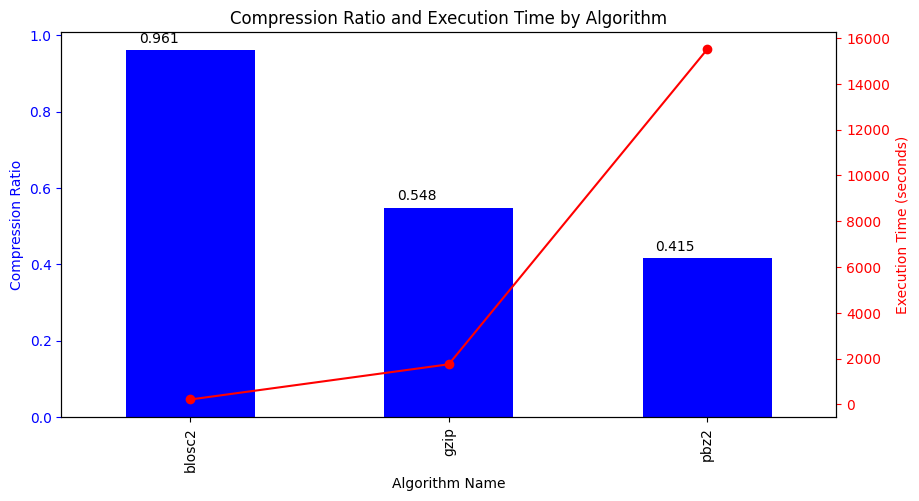

In [19]:
data = {'compression_ratio': [
            PerformanceStats('../data/wiki-news/wiki-news-300d-1M', 'gzip').get_ratio(),
            PerformanceStats('../data/wiki-news/wiki-news-300d-1M', 'pbz2').get_ratio(), 
            PerformanceStats('../data/wiki-news/wiki-news-300d-1M', 'blosc2').get_ratio()],
        'execution_time': [1750, 15500, 213],
        'algorithm_name': ['gzip', 'pbz2', 'blosc2']}

plot_performance_stats(pandas.DataFrame(data))

### Result analysis

The same pattern still applies, with almost no compression from blosc2.

If some compression is desired, than `gzip` would give good compression without too much overhead.

# Conclusion

Things to keep in mind:

1. **any compression will add loading overhead**
2. if you care more about short loading times, then use `blosc2`.  If you're lucky, you'll get some compression, depending on the nature of the original pickle
3. if you only care about small size, then use `pbz2`.  But be ready to increase your loading overhead by about 10x
4. `gzip` usually gives a more balanced trade-off


I hope this gives you some food for thought, or a head start for further analysis.

Either way, please let me know.  :)